In [1]:
# Posortuj unikalne building_id
sorted_buildings = sorted(df_final['building_id'].unique())

# Wybierz pierwsze 5 kolejnych
selected_buildings = sorted_buildings[:1]

for i in selected_buildings:
    df = df_final[df_final['building_id'] == i]

# Load your data
# df = pd.read_csv('one_building_data.csv', parse_dates=['timestamp'], index_col='timestamp')

# Ensure the data is sorted by time
df = df.set_index('timestamp').sort_index()

# Use energy_consumption as the time series
ts = df['energy_consumption']

# Split into train and test (last 7 days for testing)
train = ts[-720:-7*24]
test = ts[-7*24:]

try:

    arima_order = find_arima_params(train)
    model = ARIMA(train, order=arima_order, seasonal_order=(1,1,1,24))
    arima_model = model.fit()

    # Forecast
    forecast = arima_model.forecast(steps=len(test))

    # Evaluate
    mse = mean_squared_error(test, forecast)
    mae = mean_absolute_error(test, forecast)
    print(f"ARIMA MSE: {mse:.2f}, MAE: {mae:.2f}")

    # Plot results
    plt.figure(figsize=(12,6))
    plt.plot(train.index[-7*24:], train[-7*24:], label='Train')
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, forecast, label='ARIMA Forecast')
    plt.legend()
    plt.title('ARIMA Forecasting')
    plt.show()

except Exception as e:
    print(f"Error fitting ARIMA: {e}")

NameError: name 'df_final' is not defined

In [ ]:
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.simplefilter(action='ignore', category=FutureWarning)

# Funkcja do obliczania MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Zakładając, że df_final jest już zdefiniowane
# Posortuj unikalne building_id
sorted_buildings = sorted(df_final['building_id'].unique())

# Wybierz pierwsze 5 kolejnych
selected_buildings = sorted_buildings[:1]

for i in selected_buildings:
    data = df_final[df_final['building_id'] == i]
    data = data[(data['timestamp'].dt.year == 2017)].sort_values('timestamp')
    # data = data[(data['timestamp'].dt.year == 2017) & (data['timestamp'].dt.month == 3)].sort_values('timestamp')

    # Dla ARIMAX/SARIMAX potrzebujemy zmiennych egzogenicznych
    y = data['energy_consumption']
    X = data[['airTemperature']]  # zmienne egzogeniczne

    # Podział danych na treningowe i testowe
    train_y, test_y = train_test_split(y, test_size=24, shuffle=False)
    train_X, test_X = train_test_split(X, test_size=24, shuffle=False)

    # 1. ARIMA (bez sezonowości)
    print("\n" + "="*40)
    print("=== ARIMA ===")

    start = time.time()
    arima_model = pm.auto_arima(
        train_y,
        seasonal=False,  # Wyłącz sezonowość
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    # Prognoza ARIMA
    arima_forecast = arima_model.predict(n_periods=len(test_y))
    end = time.time()

    arima_time= end - start

    # Oblicz metryki
    arima_mse = mean_squared_error(test_y, arima_forecast)
    arima_mae = mean_absolute_error(test_y, arima_forecast)
    arima_mape = mean_absolute_percentage_error(test_y, arima_forecast)

    # Wykres ARIMA
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(train_y)), train_y, label='Train')
    plt.plot(np.arange(len(train_y), len(train_y) + len(test_y)), test_y, label='Test')
    plt.plot(np.arange(len(train_y), len(train_y) + len(test_y)), arima_forecast, label='ARIMA Forecast')
    plt.legend()
    plt.title(f"ARIMA Forecast\nMSE: {arima_mse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.2f}%")
    plt.show()

    # 2. SARIMA (z sezonowością)
    print("\n" + "="*40)
    print("=== SARIMA ===")

    start = time.time()
    sarima_model = pm.auto_arima(
        train_y,
        seasonal=True,
        m=24,  # Okres sezonowości (24 godziny)
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    # Prognoza SARIMA
    sarima_forecast = sarima_model.predict(n_periods=len(test_y))
    end = time.time()

    sarima_time = end - start

    # Oblicz metryki
    sarima_mse = mean_squared_error(test_y, sarima_forecast)
    sarima_mae = mean_absolute_error(test_y, sarima_forecast)
    sarima_mape = mean_absolute_percentage_error(test_y, sarima_forecast)

    # Wykres SARIMA
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(train_y)), train_y, label='Train')
    plt.plot(np.arange(len(train_y), len(train_y) + len(test_y)), test_y, label='Test')
    plt.plot(np.arange(len(train_y), len(train_y) + len(test_y)), sarima_forecast, label='SARIMA Forecast')
    plt.legend()
    plt.title(f"SARIMA Forecast\nMSE: {sarima_mse:.2f}, MAE: {sarima_mae:.2f}, MAPE: {sarima_mape:.2f}%")
    plt.show()

    # 3. ARIMAX (ARIMA z zmiennymi egzogenicznymi)
    print("\n" + "="*40)
    print("=== ARIMAX ===")

    start = time.time()
    arimax_model = pm.auto_arima(
        train_y,
        exogenous=train_X,
        seasonal=False,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    # Prognoza ARIMAX
    arimax_forecast = arimax_model.predict(n_periods=len(test_y), exogenous=test_X)
    end = time.time()

    arimax_time = end - start

    # Oblicz metryki
    arimax_mse = mean_squared_error(test_y, arimax_forecast)
    arimax_mae = mean_absolute_error(test_y, arimax_forecast)
    arimax_mape = mean_absolute_percentage_error(test_y, arimax_forecast)

    # Wykres ARIMAX
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(train_y)), train_y, label='Train')
    plt.plot(np.arange(len(train_y), len(train_y) + len(test_y)), test_y, label='Test')
    plt.plot(np.arange(len(train_y), len(train_y) + len(test_y)), arimax_forecast, label='ARIMAX Forecast')
    plt.legend()
    plt.title(f"ARIMAX Forecast\nMSE: {arimax_mse:.2f}, MAE: {arimax_mae:.2f}, MAPE: {arimax_mape:.2f}%")
    plt.show()

    # 4. SARIMAX (SARIMA z zmiennymi egzogenicznymi)
    print("\n" + "="*40)
    print("=== SARIMAX ===")

    start = time.time()
    sarimax_model = pm.auto_arima(
        train_y,
        exogenous=train_X,
        seasonal=True,
        m=24,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    # Prognoza SARIMAX
    sarimax_forecast = sarimax_model.predict(n_periods=len(test_y), exogenous=test_X)
    end = time.time()

    sarimax_time = end - start

    # Oblicz metryki
    sarimax_mse = mean_squared_error(test_y, sarimax_forecast)
    sarimax_mae = mean_absolute_error(test_y, sarimax_forecast)
    sarimax_mape = mean_absolute_percentage_error(test_y, sarimax_forecast)

    # Wykres SARIMAX
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(train_y)), train_y, label='Train')
    plt.plot(np.arange(len(train_y), len(train_y) + len(test_y)), test_y, label='Test')
    plt.plot(np.arange(len(train_y), len(train_y) + len(test_y)), sarimax_forecast, label='SARIMAX Forecast')
    plt.legend()
    plt.title(f"SARIMAX Forecast\nMSE: {sarimax_mse:.2f}, MAE: {sarimax_mae:.2f}, MAPE: {sarimax_mape:.2f}%")
    plt.show()

    # Porównanie metryk wszystkich modeli
    print("\n" + "="*40)
    print("=== Podsumowanie metryk ===")
    metrics_df = pd.DataFrame({
        'Model': ['ARIMA', 'SARIMA', 'ARIMAX', 'SARIMAX'],
        'MSE': [arima_mse, sarima_mse, arimax_mse, sarimax_mse],
        'MAE': [arima_mae, sarima_mae, arimax_mae, sarimax_mae],
        'MAPE': [arima_mape, sarima_mape, arimax_mape, sarimax_mape],
        'Czas': [arima_time, sarima_time, arimax_time, sarimax_time,]
    })
    print(metrics_df)

##### LSTM

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.src.layers import BatchNormalization, Dropout
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import warnings
import keras_tuner as kt
import itertools
import time
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf

warnings.filterwarnings('ignore')

In [3]:
df_final = pd.read_csv("all_data.csv", parse_dates=['timestamp'])

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Parametry
n_steps = 24  # 24 godziny historii
n_features = 3  # energy_consumption + airTemperature + sqm

# Funkcja przygotowująca dane treningowe
def prepare_train_data(data, target_col, n_steps):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(data)

    X, y = [], []
    for i in range(n_steps, len(scaled)):
        X.append(scaled[i-n_steps:i, :])
        y.append(scaled[i, data.columns.get_loc(target_col)])

    return np.array(X), np.array(y), scaler

# Funkcja przygotowująca dane testowe z historią z treningu
def prepare_test_data(train_data, test_data, scaler, n_steps):
    # Połącz ostatnie n_steps z treningu z testem
    combined = pd.concat([train_data.iloc[-n_steps:], test_data])
    scaled = scaler.transform(combined)

    X_test = []
    for i in range(n_steps, len(scaled)):
        X_test.append(scaled[i-n_steps:i, :])

    return np.array(X_test)

# Budowa modelu
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', 32, 256, step=32),
        input_shape=(n_steps, n_features),
        return_sequences=False
    ))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mse'
    )
    return model

# Główny proces
def train_and_predict(train_data, test_data, target_col):
    # 1. Przygotowanie danych treningowych
    X_train, y_train, scaler = prepare_train_data(train_data, target_col, n_steps)

    # 2. Strojenie i trening modelu
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=10,
        directory='tuning',
        project_name='energy_forecast'
    )

    tuner.search(X_train, y_train, epochs=20, validation_split=0.2)
    best_model = tuner.get_best_models()[0]

    # 3. Przygotowanie danych testowych z historią
    X_test = prepare_test_data(train_data, test_data, scaler, n_steps)

    # 4. Predykcja dla 168 godzin
    predictions = best_model.predict(X_test)

    # 5. Odwrócenie skalowania
    dummy = np.zeros((len(predictions), n_features))
    dummy[:, 0] = predictions.flatten()
    preds = scaler.inverse_transform(dummy)[:, 0]

    return preds, test_data[target_col].values

# Wczytanie i przygotowanie danych
df = pd.read_csv('one_building_data.csv', parse_dates=['timestamp'], index_col='timestamp')
df = df.sort_index()

# Wybór cech i targetu
features = ['energy_consumption', 'airTemperature', 'sqm']
target = 'energy_consumption'
data = df[features].dropna()

# Podział na trening (30 dni) i test (7 dni)
train = data.iloc[-720:-168]  # 30 dni treningu
test = data.iloc[-168:]       # 7 dni testu

# Uruchomienie procesu
predictions, true_values = train_and_predict(train, test, target)

# Ocena wyników
mse = mean_squared_error(true_values, predictions)
mae = mean_absolute_error(true_values, predictions)

print(f"MSE: {mse:.2f}, MAE: {mae:.2f}")
print(f"Liczba przewidzianych godzin: {len(predictions)}")

Trial 10 Complete [00h 00m 23s]
val_loss: 0.016311530023813248

Best val_loss So Far: 0.008441483601927757
Total elapsed time: 00h 02m 47s
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
MSE: 3.00, MAE: 1.33
Liczba przewidzianych godzin: 168


In [26]:
results = pd.DataFrame(index=test.index)
results['LSTM'] = predictions
# Ewaluacja
def evaluate_model(y_true, y_pred, model_name, training_time=None):
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'Czas treningu': training_time
    }
    return pd.DataFrame([metrics], index=[model_name])

print(evaluate_model(true_values, predictions, 'LSTM'))


          RMSE       MAE      MAPE Czas treningu
LSTM  1.731665  1.325876  0.214544          None


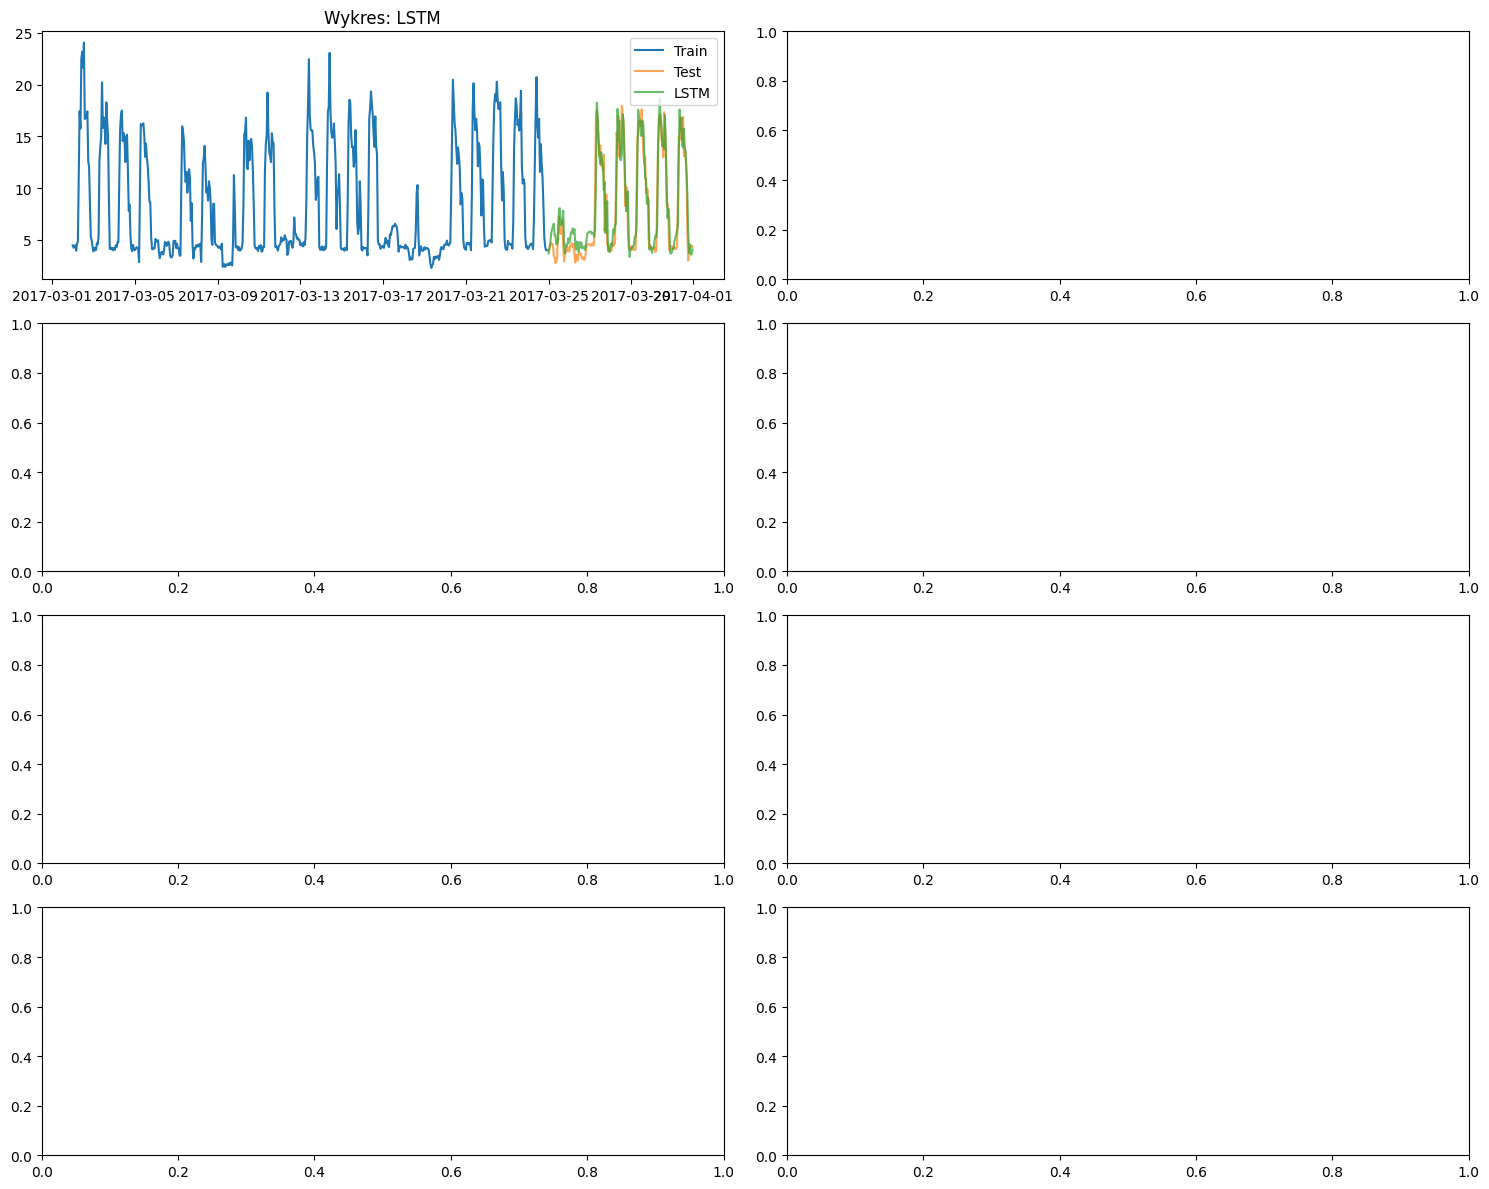

In [27]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
axes = axes.flatten()  # Spłaszczenie do 1D listy osi
train = data['energy_consumption'][-720:-168]  # 30 dni treningu
test = data[-168:]
for i, col in enumerate(results.columns[:8]):
    ax = axes[i]
    ax.plot(data['energy_consumption'][-720:-168], label='Train')
    ax.plot(data['energy_consumption'][-168:], label='Test', alpha=0.7)
    ax.plot(results[col], label=col, alpha=0.7)
    ax.set_title(f'Wykres: {col}')
    ax.legend()

plt.tight_layout()
plt.show()

# # 10. Podsumowanie metryk
# metrics_df = pd.DataFrame(metrics).set_index('Model')
# print("\nMetryki efektywności:")
# print(metrics_df.sort_values('RMSE'))


                               SARIMAX Results                                
Dep. Variable:     energy_consumption   No. Observations:                  552
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3003.109
Date:                Sat, 14 Jun 2025   AIC                           6012.218
Time:                        02:53:11   BIC                           6025.154
Sample:                             0   HQIC                          6017.273
                                - 552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1573      0.189      0.834      0.404      -0.212       0.527
ma.L1          0.1481      0.186      0.795      0.426      -0.217       0.513
sigma2      3173.2694     82.292     38.561      0.0

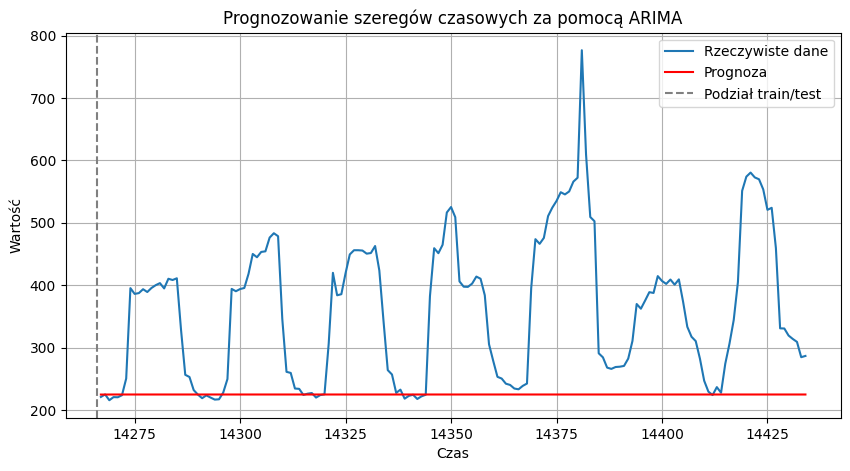

                               SARIMAX Results                                
Dep. Variable:     energy_consumption   No. Observations:                  552
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1850.538
Date:                Sat, 14 Jun 2025   AIC                           3707.076
Time:                        02:53:13   BIC                           3720.012
Sample:                             0   HQIC                          3712.131
                                - 552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4599      0.371     -1.239      0.215      -1.188       0.268
ma.L1          0.5297      0.359      1.475      0.140      -0.174       1.234
sigma2        48.3803      1.492     32.418      0.0

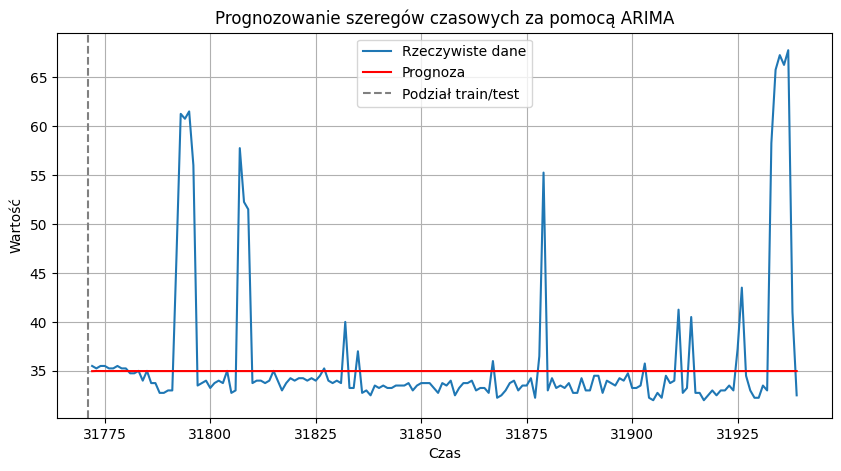

                               SARIMAX Results                                
Dep. Variable:     energy_consumption   No. Observations:                  552
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2016.491
Date:                Sat, 14 Jun 2025   AIC                           4038.982
Time:                        02:53:14   BIC                           4051.917
Sample:                             0   HQIC                          4044.037
                                - 552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5465      0.090      6.044      0.000       0.369       0.724
ma.L1         -0.0801      0.112     -0.718      0.473      -0.299       0.139
sigma2        88.3237      3.646     24.224      0.0

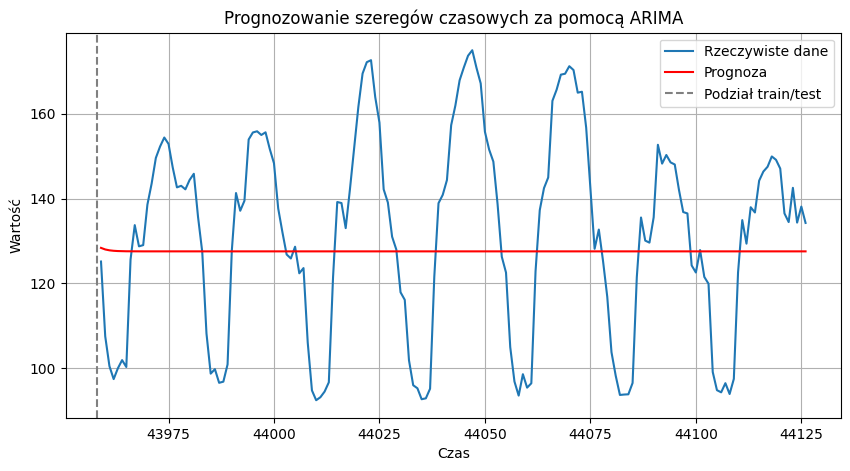

                               SARIMAX Results                                
Dep. Variable:     energy_consumption   No. Observations:                  552
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  38.117
Date:                Sat, 14 Jun 2025   AIC                            -70.233
Time:                        02:53:15   BIC                            -57.298
Sample:                             0   HQIC                           -65.179
                                - 552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7776      0.019     41.079      0.000       0.741       0.815
ma.L1         -0.9998      0.252     -3.971      0.000      -1.493      -0.506
sigma2         0.0506      0.013      3.951      0.0

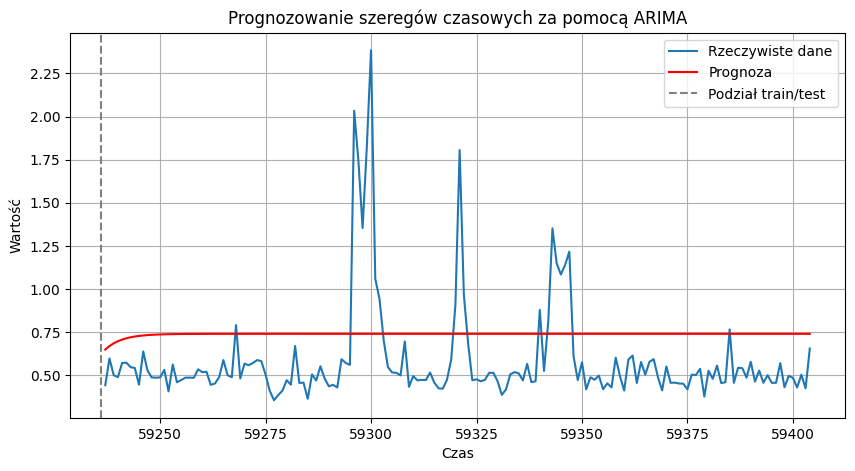

                               SARIMAX Results                                
Dep. Variable:     energy_consumption   No. Observations:                  552
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2758.728
Date:                Sat, 14 Jun 2025   AIC                           5523.455
Time:                        02:53:16   BIC                           5536.390
Sample:                             0   HQIC                          5528.510
                                - 552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7936      0.118     -6.702      0.000      -1.026      -0.561
ma.L1          0.8430      0.110      7.649      0.000       0.627       1.059
sigma2      1307.1430     27.147     48.151      0.0

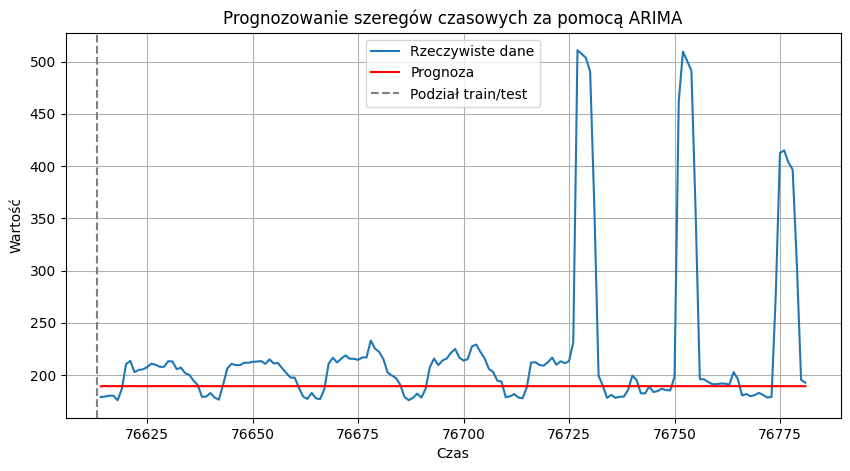

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Generowanie sztucznego szeregu czasowego (np. dane miesięczne)
sorted_buildings = sorted(df_final['building_id'].unique())

# Wybierz pierwsze 5 kolejnych
selected_buildings = sorted_buildings[:5]

for i in selected_buildings:
    data = df_final[df_final['building_id'] == i]
    data = data[(data['timestamp'].dt.year == 2017)].sort_values('timestamp')

    # Dla ARIMAX/SARIMAX potrzebujemy zmiennych egzogenicznych
    y = data['energy_consumption']
    X = data[['airTemperature']]  # zmienne egzogeniczne


    # Podział danych: uczące i testowe
    train = y[-720:-168]
    test = y[-168:]

    # Tworzenie i dopasowanie modelu ARIMA
    # Parametry (p, d, q): p=1 (autoregresja), d=1 (różnicowanie), q=1 (średnia ruchoma)
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()

    # Wyświetlenie podsumowania
    print(model_fit.summary())

    # Prognoza na długość testu
    forecast = model_fit.forecast(steps=len(test))

    # 📊 Wizualizacja wyników
    plt.figure(figsize=(10, 5))
    plt.plot(test.index, test, label='Rzeczywiste dane')
    plt.plot(test.index, forecast, label='Prognoza', color='red')
    plt.axvline(x=train.index[-1], color='gray', linestyle='--', label='Podział train/test')
    plt.legend()
    plt.title('Prognozowanie szeregów czasowych za pomocą ARIMA')
    plt.xlabel('Czas')
    plt.ylabel('Wartość')
    plt.grid(True)
    plt.show()


##### ARIMAS


In [42]:
def evaluate_model(y_true, y_pred, model_name, trening_time=None, model_time=None):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {'Model': model_name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'Czas treningu': trening_time, 'Czas predykcji': model_time}


In [35]:
def find_arima_params(train):

    d = determine_differencing_order(train)
    stationary_series = train.diff(d).dropna() if d > 0 else train.copy()

    max_lags = 20
    acf_vals = acf(stationary_series, nlags=max_lags, fft=True)
    pacf_vals = pacf(stationary_series, nlags=max_lags)

    p_range = suggest_p_from_pacf(pacf_vals)
    q_range = suggest_q_from_acf(acf_vals)

    best_aic = np.inf
    best_order = (1, d, 1)

    # Generuj wszystkie kombinacje p i q
    pdq = itertools.product(p_range, [d], q_range)

    for order in pdq:
        try:
            model = ARIMA(train, order=order).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
        except:
            continue

    validated_order = validate_arima_order(train, best_order)

    warnings.resetwarnings()
    return validated_order


def determine_differencing_order(series, max_diff=2):
    """
    Określa rząd różnicowania (d) na podstawie testów stacjonarności
    """
    for d in range(max_diff + 1):
        if d > 0:
            diff_series = series.diff(d).dropna()
        else:
            diff_series = series.copy()

        # Test ADF
        adf_result = adfuller(diff_series)
        # Test KPSS
        try:
            kpss_result = kpss(diff_series, regression='c')
        except:
            kpss_result = (None, 1.0)

        if adf_result[1] <= 0.05 and kpss_result[1] > 0.05:
            return d

    return max_diff  # Zwróć maksymalny testowany rząd


def suggest_p_from_pacf(pacf_vals, threshold=0.2):
    """
    Sugeruje zakres p na podstawie PACF
    """
    significant_lags = np.where(np.abs(pacf_vals) > threshold)[0]
    if len(significant_lags) > 0:
        max_p = min(np.max(significant_lags) + 2, 5)  # Ogranicz do 5
        return range(0, max_p + 1)
    return [0, 1, 2]


def suggest_q_from_acf(acf_vals, threshold=0.2):
    """
    Sugeruje zakres q na podstawie ACF
    """
    significant_lags = np.where(np.abs(acf_vals) > threshold)[0]
    if len(significant_lags) > 0:
        max_q = min(np.max(significant_lags) + 2, 5)  # Ogranicz do 5
        return range(0, max_q + 1)
    return [0, 1, 2]


def validate_arima_order(series, order, n_folds=3):
    """
    Walidacja parametrów z użyciem kroczącej walidacji
    """
    p, d, q = order
    train_size = len(series)
    fold_size = train_size // (n_folds + 1)

    aic_scores = []

    for i in range(1, n_folds + 1):
        train = series.iloc[:i * fold_size]
        try:
            model = ARIMA(train, order=order).fit()
            aic_scores.append(model.aic)
        except:
            aic_scores.append(np.inf)

    # Sprawdź czy prostsze modele nie dają podobnych wyników
    simpler_models = [
        (max(p - 1, 0), d, q),
        (p, d, max(q - 1, 0)),
        (max(p - 1, 0), d, max(q - 1, 0))
    ]

    for test_order in simpler_models:
        try:
            model = ARIMA(series, order=test_order).fit()
            if model.aic < np.mean(aic_scores):
                return test_order
        except:
            continue

    return order

In [38]:
def find_optimal_seasonal_params(train, s=24, non_seasonal_order=(1, 1, 1)):

    D = determine_seasonal_differencing_order(train, s)
    P_range = [0, 1, 2]
    Q_range = [0, 1, 2]

    best_aic = np.inf
    best_order = (1, D, 1, s)

    for P, Q in itertools.product(P_range, Q_range):
        seasonal_order = (P, D, Q, s)
        try:
            model = SARIMAX(train,
                            order=non_seasonal_order,
                            seasonal_order=seasonal_order).fit(disp=False)

            if model.aic < best_aic:
                best_aic = model.aic
                best_order = seasonal_order
        except:
            continue

    warnings.resetwarnings()
    return best_order


def determine_seasonal_differencing_order(series, s, max_D=1):
    """
    Określa sezonowy rząd różnicowania (D) na podstawie:
    - Testu Canova-Hansona dla sezonowości
    - Wizualnej inspecji sezonowych ACF
    """
    # Test Canova-Hansona (dostępny w statsmodels 0.14+)
    try:
        from statsmodels.tsa.statespace.tools import seasonal_decompose
        decomposition = seasonal_decompose(series, period=s)
        resid = decomposition.resid.dropna()
        if abs(resid).mean() < 0.1 * abs(series).mean():
            return 0
    except:
        pass

    # Różnicowanie sezonowe i test ACF
    for D in range(max_D + 1):
        if D > 0:
            diff_series = series.diff(s).dropna()
        else:
            diff_series = series.copy()

        # Sprawdź czy sezonowość została usunięta
        acf_vals = acf(diff_series, nlags=s + 3, fft=True)
        if all(abs(acf_vals[s - 1:s + 2]) < 0.2):  # Sprawdź opóźnienie sezonowe
            return D

    return max_D


In [44]:
def doArimaModels(trainDataARIMA, exogData = None):

    arimaTimes = dict()

    start = time.time()
    # arima_order = find_arima_params(trainDataARIMA)
    arima_order = (1,1,1)
    end = time.time()
    arimaTimes["arimaSearch"] = end - start

    start = time.time()
    am = ARIMA(trainDataARIMA, order=arima_order).fit()
    end = time.time()
    arimaTimes["ARIMA"] = end - start

    start = time.time()
    # seasonal_order = find_optimal_seasonal_params(trainDataARIMA, s=24, non_seasonal_order=arima_order)
    seasonal_order = (1,1,1,24)
    end = time.time()
    arimaTimes["arimaSeasonalSearch"] = end - start

    start = time.time()
    sm = SARIMAX(trainDataARIMA, order=arima_order, seasonal_order=seasonal_order).fit()
    end = time.time()
    arimaTimes["SARIMA"] = end - start

    if isinstance(exogData, pd.DataFrame):
        start = time.time()
        axm = ARIMA(trainDataARIMA, exog=exogData, order=arima_order).fit()
        end = time.time()
        arimaTimes["ARIMAX"] = end - start

        start = time.time()
        sxm = SARIMAX(trainDataARIMA, exog=exogData, order=arima_order,
                                seasonal_order=seasonal_order).fit()
        end = time.time()
        arimaTimes["SARIMAX"] = end - start
    else:
        axm = None
        sxm = None


    return am, sm, axm, sxm, arimaTimes


##### TEST

In [43]:
warnings.filterwarnings('ignore')

# Posortuj unikalne building_id
sorted_buildings = sorted(df_final['building_id'].unique())

# Wybierz pierwsze 5 kolejnych
selected_buildings = sorted_buildings[:1]

all_results = []
all_metrics = []
num = 1
for i in selected_buildings:
    print(f"----------ITER {i} - {num} END ----------")
    data = df_final[df_final['building_id'] == i].copy()  # Use copy() to avoid SettingWithCopyWarning
    # data['timestamp'] = pd.to_datetime(data['timestamp'])  # Ensure timestamp is datetime type
    # data = data.set_index('timestamp').sort_index()

    # Optional cleaning steps (equivalent to your original data_clean line)
    # df = data.replace([np.inf, -np.inf], np.nan).dropna(subset=['airTemperature','energy_consumption'])


    # df = pd.read_csv('one_building_data.csv', parse_dates=['timestamp'], index_col='timestamp')

    # Ensure the data is sorted by time
    # df = df.sort_index()

    df['timestamp'] = pd.to_datetime(data['timestamp'])
    df = df.set_index('timestamp').sort_index()

    # Czyszczenie danych: tylko potrzebne kolumny, usunięcie NaN, inf
    df = df[['energy_consumption', 'airTemperature']].replace([np.inf, -np.inf], np.nan).dropna()

    target = df['energy_consumption']
    exog = df[['airTemperature']]  # Add other variables if needed

    train = target[-720:-7*24]
    test = target[-7*24:]

    train = train.astype(float)
    test = test.astype(float)

    exogTrain = exog[-720:-7*24]
    exogTest = exog[-7*24:]

    # auto_arima_model, auto_sarima_model, auto_arimax_model, auto_sarimax_model, autoArimaTimes = doAutoARIMA(train, test, exogTrain, exogTest)

    # # ARIMA - własna
    arima_model, sarima_model, arimax_model, sarimax_model, arimaTimes = doArimaModels(train, exogTrain)
    print("ARIMA DONE")
    results = pd.DataFrame(index=test.index)

    metrics = []
    # ARIMA
    results['ARIMA'] = arima_model.forecast(steps=len(test))
    metrics.append(evaluate_model(test, results['ARIMA'], 'ARIMA', model_time=arimaTimes['ARIMA'], trening_time=arimaTimes['arimaSearch']))

    # SARIMA
    results['SARIMA'] = sarima_model.forecast(steps=len(test))
    metrics.append(evaluate_model(test, results['SARIMA'], 'SARIMA', model_time=arimaTimes['SARIMA'], trening_time=arimaTimes['arimaSeasonalSearch']))

    #ARIMAX
    results['ARIMAX'] = arimax_model.forecast(steps=len(test), exog=exogTest)
    metrics.append(evaluate_model(test, results['ARIMAX'], 'ARIMAX', model_time=arimaTimes['ARIMAX']))

    #SARIMAX
    results['SARIMAX'] = sarimax_model.forecast(steps=len(test), exog=exogTest)
    metrics.append(evaluate_model(test, results['SARIMAX'], 'SARIMAX', model_time=arimaTimes['SARIMAX']))

    # # Auto ARIMA
    # results['AutoARIMA'] = auto_arima_model.predict(n_periods=len(test))
    # results['AutoARIMA'] = fill_nan_with_neighbors(results['AutoARIMA'])
    # metrics.append(evaluate_model(test, results['AutoARIMA'], 'AutoARIMA', model_time=autoArimaTimes['AutoARIMA']))
    #
    # # Auto SARIMA
    # results['AutoSARIMA'] = auto_sarima_model.predict(n_periods=len(test))
    # results['AutoSARIMA'] = fill_nan_with_neighbors(results['AutoSARIMA'])
    # metrics.append(evaluate_model(test, results['AutoSARIMA'], 'AutoSARIMA', model_time=autoArimaTimes['AutoSARIMA']))
    #
    # # Auto ARIMAX
    # results['AutoARIMAX'] = auto_arimax_model.predict(n_periods=len(test), exogenous=exogTest)
    # results['AutoARIMAX'] = fill_nan_with_neighbors(results['AutoARIMAX'])
    # metrics.append(evaluate_model(test, results['AutoARIMAX'], 'AutoARIMAX', model_time=autoArimaTimes['AutoARIMAX']))
    #
    # # Auto SARIMAX
    # results['AutoSARIMAX'] = auto_sarimax_model.predict(n_periods=len(test), exogenous=exogTest)
    # results['AutoSARIMAX'] = fill_nan_with_neighbors(results['AutoSARIMAX'])
    # metrics.append(evaluate_model(test, results['AutoSARIMAX'], 'AutoSARIMAX', model_time=autoArimaTimes['AutoSARIMAX']))

    all_metrics.append(metrics)
    all_results.append(results)

    print(f"----------ITER {i} - {num} END ----------")
    num += 1


----------ITER Bear_assembly_Angel - 1 END ----------
timestamp
NaT    4.4650
NaT    4.2400
NaT    4.3275
NaT    4.4725
NaT    3.9375
        ...  
NaT    5.2825
NaT    4.3650
NaT    4.0000
NaT    3.9850
NaT    3.9950
Name: energy_consumption, Length: 552, dtype: float64
ARIMA DONE


ValueError: Input contains NaN.

In [70]:
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.simplefilter(action='ignore', category=FutureWarning)

sorted_buildings = sorted(df_final['building_id'].unique())
selected_buildings = sorted_buildings[1:2]

for i in selected_buildings:
    print(f"\n\n====== Budynek {i} ======")
    data = df_final[df_final['building_id'] == i]
    data = data[(data['timestamp'].dt.year == 2017)].sort_values('timestamp')

    # Ustaw indeks czasowy
    data = data.set_index('timestamp')

    # Usuwanie ewentualnych NaN
    data = data[['energy_consumption', 'airTemperature']].dropna()

    y = data['energy_consumption']
    X = data[['airTemperature']]  # zmienne egzogeniczne (do ewentualnego SARIMAX)

    # Podział na dane uczące i testowe
    train = y[-720:-168]
    test = y[-168:]

    exogTrain = X[-720:-168]
    exogTest = X[-168:]

    print(f"Rozmiar train: {len(train)}, test: {len(test)}")
    print(f"Czy są NaN w train? {train.isna().sum()}")
    print(f"train index: {train.index[:3]} ... {train.index[-3:]}")

    arimaTimes = dict()
    arima_order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 24)

    try:
        # ARIMA
        start = time.time()
        am = ARIMA(train, order=arima_order)
        arima_model = am.fit()
        forecast_arima = arima_model.forecast(steps=len(test))
        end = time.time()
        arimaTimes["ARIMA"] = end - start

        print("ARIMA forecast NaNs:", forecast_arima.isna().sum())

    except Exception as e:
        print("Błąd ARIMA:", e)
        forecast_arima = pd.Series([np.nan] * len(test), index=test.index)
        arimaTimes["ARIMA"] = 0

    try:
        # SARIMA
        start = time.time()
        sm = SARIMAX(train, order=arima_order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        sarima_model = sm.fit(disp=False)
        forecast_sarima = sarima_model.forecast(steps=len(test))
        end = time.time()
        arimaTimes["SARIMA"] = end - start

        print("SARIMA forecast NaNs:", forecast_sarima.isna().sum())

    except Exception as e:
        print("Błąd SARIMA:", e)
        forecast_sarima = pd.Series([np.nan] * len(test), index=test.index)
        arimaTimes["SARIMA"] = 0

    try:
        # ARIMAX
        start = time.time()
        axm = ARIMA(train, exog=exogTrain, order=arima_order)
        arimax_model = axm.fit()
        forecast_arimax = arimax_model.forecast(steps=len(test), exog=exogTest)
        end = time.time()
        arimaTimes["ARIMAX"] = end - start

        print("ARIMAX forecast NaNs:", forecast_arimax.isna().sum())

    except Exception as e:
        print("Błąd ARIMAX:", e)
        forecast_arimax = pd.Series([np.nan] * len(test), index=test.index)
        arimaTimes["ARIMAX"] = 0

    try:
        # SARIMAX
        start = time.time()
        sxm = SARIMAX(train, exog=exogTrain, order=arima_order,
                                seasonal_order=seasonal_order)
        sarimax_model = sxm.fit()
        forecast_sarimax = sarimax_model.forecast(steps=len(test), exog=exogTest)
        end = time.time()
        arimaTimes["SARIMAX"] = end - start

        print("SARIMAX forecast NaNs:", forecast_sarimax.isna().sum())

    except Exception as e:
        print("Błąd SARIMAX:", e)
        forecast_sarimax = pd.Series([np.nan] * len(test), index=test.index)
        arimaTimes["SARIMAX"] = 0


    try:
        # autoARIMA
        start = time.time()
        auto_arima_model = pm.auto_arima(
            train,
            seasonal=False,  # Wyłącz sezonowość
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )

        #auto_arimax_model.predict(n_periods=len(test), exogenous=exogTest)
        forecast_auto_arima = auto_arima_model.predict(n_periods=len(test))
        end = time.time()
        arimaTimes["AutoARIMA"] = end - start

        print("AutoARIMA forecast NaNs:", forecast_auto_arima.isna().sum())

    except Exception as e:
        print("Błąd AutoARIMA:", e)
        forecast_auto_arima = pd.Series([np.nan] * len(test), index=test.index)
        arimaTimes["AutoARIMA"] = 0

    try:
        # autoSARIMA
        start = time.time()
        auto_sarima_model = pm.auto_arima(
            train,
            seasonal=True,
            m=24,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )

        #auto_arimax_model.predict(n_periods=len(test), exogenous=exogTest)
        forecast_auto_sarima = auto_sarima_model.predict(n_periods=len(test))
        end = time.time()
        arimaTimes["AutoSARIMA"] = end - start

        print("AutoSARIMA forecast NaNs:", forecast_auto_sarima.isna().sum())

    except Exception as e:
        print("Błąd AutoARIMAX:", e)
        forecast_auto_sarima = pd.Series([np.nan] * len(test), index=test.index)
        arimaTimes["AutoARIMAX"] = 0

    try:
        # autoARIMAX
        start = time.time()
        auto_sarima_model = pm.auto_arima(
            train,
            exogenous=exogTrain,
            seasonal=False,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )

        #auto_arimax_model.predict(n_periods=len(test), exogenous=exogTest)
        forecast_auto_arimax = auto_sarima_model.predict(n_periods=len(test), exogenous=exogTest)
        end = time.time()
        arimaTimes["AutoARIMAX"] = end - start

        print("AutoARIMAX forecast NaNs:", forecast_auto_arimax.isna().sum())

    except Exception as e:
        print("Błąd AutoARIMAX:", e)
        forecast_auto_arimax = pd.Series([np.nan] * len(test), index=test.index)
        arimaTimes["AutoARIMAX"] = 0

    try:
        # autoSARIMAX
        start = time.time()
        auto_sarimax_model = pm.auto_arima(
            train,
            exogenous=exogTrain,
            seasonal=True,
            m=24,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )

        #auto_arimax_model.predict(n_periods=len(test), exogenous=exogTest)
        forecast_auto_sarimax = auto_sarimax_model.predict(n_periods=len(test), exogenous=exogTest)
        end = time.time()
        arimaTimes["AutoSARIMAX"] = end - start

        print("AutoSARIMAX forecast NaNs:", forecast_auto_sarimax.isna().sum())

    except Exception as e:
        print("Błąd AutoSARIMAX:", e)
        forecast_auto_sarimax = pd.Series([np.nan] * len(test), index=test.index)
        arimaTimes["AutoSARIMAX"] = 0

    results = pd.DataFrame(index=test.index)
    metrics = []

    results['ARIMA'] = forecast_arima
    results['AutoARIMA'] = forecast_auto_arima
    results['ARIMAX'] = forecast_arimax
    results['AutoARIMAX'] = forecast_auto_arimax
    results['SARIMA'] = forecast_sarima
    results['AutoSARIMA'] = forecast_auto_sarima
    results['SARIMAX'] = forecast_sarimax
    results['AutoSARIMAX'] = forecast_auto_sarimax

    # Zakładam że masz evaluate_model (jeśli nie, po prostu usuń linie z metrics.append)
    try:
        metrics.append(evaluate_model(test, results['ARIMA'], 'ARIMA', model_time=arimaTimes['ARIMA'], trening_time=0))
        metrics.append(evaluate_model(test, results['SARIMA'], 'SARIMA', model_time=arimaTimes['SARIMA'], trening_time=0))
    except Exception as e:
        print("Błąd w evaluate_model:", e)

    print(results.head())



====== Budynek Bear_assembly_Beatrice ======
Rozmiar train: 552, test: 168
Czy są NaN w train? 0
train index: DatetimeIndex(['2017-12-01 23:00:00', '2017-12-02 00:00:00',
               '2017-12-02 01:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None) ... DatetimeIndex(['2017-12-24 20:00:00', '2017-12-24 21:00:00',
               '2017-12-24 22:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)
ARIMA forecast NaNs: 0
SARIMA forecast NaNs: 0
ARIMAX forecast NaNs: 0
SARIMAX forecast NaNs: 0
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3695.697, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3712.742, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3714.264, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3714.080, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3710.769, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3695.359, Time=0.30 sec
 ARIMA(0,1,2)(0

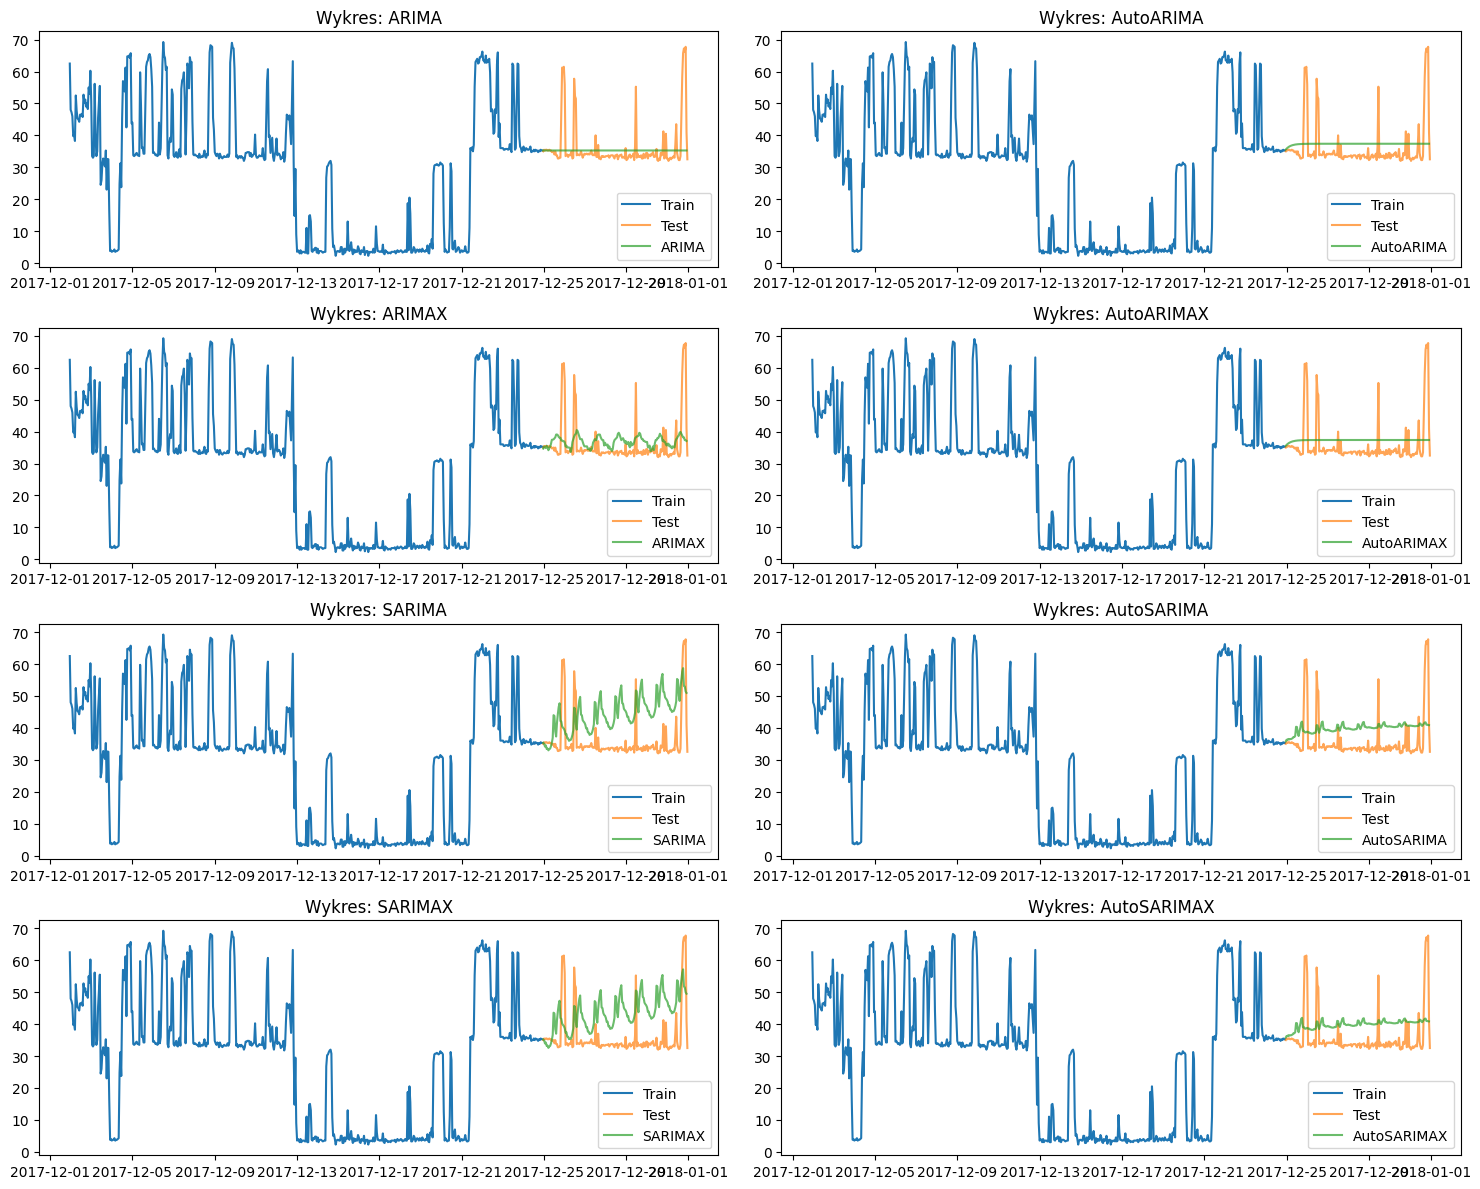

In [71]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
axes = axes.flatten()  # Spłaszczenie do 1D listy osi

for i, col in enumerate(results.columns[:8]):
    ax = axes[i]
    ax.plot(train, label='Train')
    ax.plot(test, label='Test', alpha=0.7)
    ax.plot(results[col], label=col, alpha=0.7)
    ax.set_title(f'Wykres: {col}')
    ax.legend()

plt.tight_layout()
plt.show()

# # 10. Podsumowanie metryk
# metrics_df = pd.DataFrame(metrics).set_index('Model')
# print("\nMetryki efektywności:")
# print(metrics_df.sort_values('RMSE'))
